# About cvs_skills_analysis.ipynb
This notebook reports different statistics and visuals on the use of CVS like skills by students

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 7
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
First we load the data generated by the cvs_skills_detector.ipynb
We also grab the order in which students did the activities using the metadata file and we adjust the detection of CVS given how large the sample size should be to consider use of CVS.

We also load a copy of the data but binarized to facilitate analysis.

In [3]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [4]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [5]:
graph_cvs_df = graph_cvs_df.replace(to_replace=2,value=0)
table_cvs_df = table_cvs_df.replace(to_replace=2,value=0)
print len(table_cvs_df),len(graph_cvs_df)

149 149


In [6]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum beers'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
graph_cvs_df2['sum caps'] = graph_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
graph_cvs_df2['sum beers'] = graph_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)

In [7]:
print "Of all {0} students, {1} didn't do CVS in the table and {2} in the graph.".format(len(table_cvs_df2), sum(table_cvs_df2['sum']==0),sum(graph_cvs_df2['sum']==0))
print "On average, out of a max of six variables, students did CVS on {0}+/-{1} variables in the table and {2}+/-{3} in the graph.".format(np.mean(table_cvs_df2['sum'].values),np.std(table_cvs_df2['sum'].values),np.mean(graph_cvs_df2['sum'].values),np.std(graph_cvs_df2['sum'].values))
table_cvs_df.head()

Of all 149 students, 14 didn't do CVS in the table and 47 in the graph.
On average, out of a max of six variables, students did CVS on 3.41610738255+/-2.04020222429 variables in the table and 2.34899328859+/-2.06578445862 in the graph.


studentid  Battery voltage  Area  Separation  Wavelength  Width  \
0   11612162                0     0           0           3      0   
1   13660166                0     0           0           0      0   
2   41947147                0     0           0          14      6   
3   64006159                0     0           0           5      0   
4   15749160                0     0           3           0      4   

   Concentration activity order  
0              3             CL  
1             14             LC  
2              7             CL  
3              6             LC  
4             10             CL

# CVS in the table - how is it used?

## How many students are doing CVS for each variable?

In [8]:
print "Percentage of students doing CVS for variable in table."
p = [['',' %']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df2[v].values)*100,1)])
print tabulate(p)

Percentage of students doing CVS for variable in table.
---------------  ----
                 %
Battery voltage  47.7
Area             56.4
Separation       53.0
Wavelength       59.7
Width            59.7
Concentration    65.1
---------------  ----


CVS was done between 47 and 65 % of the time per variable. Battery voltage the least (no surprise there). Concentration the most, maybe because it had the easiest controls (with the tick marks)?

## When they do CVS, how many points do they take?

In [9]:
print "Mean sample size for each variable, excluding sample sizes of zero."
p = [['',' Mean number of pts']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df[table_cvs_df[v]!=0][v].values),1)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero.
---------------  ------------------
                 Mean number of pts
Battery voltage  5.9
Area             6.0
Separation       5.8
Wavelength       8.3
Width            6.8
Concentration    6.4
---------------  ------------------


***note:** this is the mean for sample size given students did use cvs (excluding zeroes)*

most are between 6-7. Wavelength stands out with a average of 8. No surprise there given the complexity of the relationship. Still 5-6 as a sample size is substantial!

## Great so they use it, but are students consistent in their use of CVS accross sims?

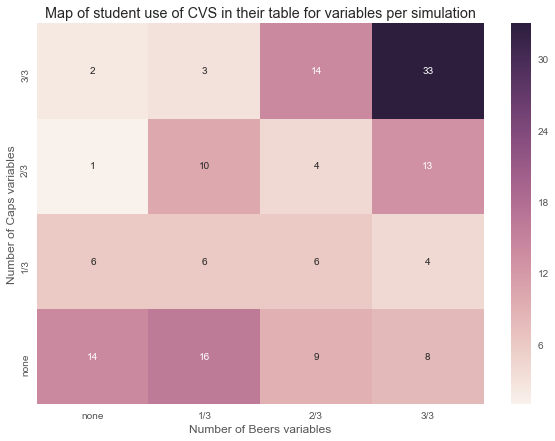

In [10]:
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their table for variables per simulation')

Overall their behavior is not consistent between sims (absence of diagonal). However students who use CVS on 2 or 3 variables tend to do so for both sims (heavy upper corner). Another pattern we see is that students who do not use CVS in the capacitance sim are still 70% likely to use CVS in the beers sim (lowest row: (16+9+8=) 35 students out of (14+16+9+8=) 49).

Heavy use of CVS is consitent
<p> &#9654; CVS proficient students are systematic </p>

Low use of CVS is different between sims
<p> &#9654; CVS non-proficient students are not systematic </p>
___
**NOTE:** We should use this visualization to find groups of students whose activity it might be interesting to visualize. For example, the 14 (out of 149, so ~ 10%) of students who never use CVS. What do they do? Are they still be systematic in their inquiry but simply not using the "record" button?

# Activity order and student learning in inquiry - part 1.

## Does order matter in their consistency?

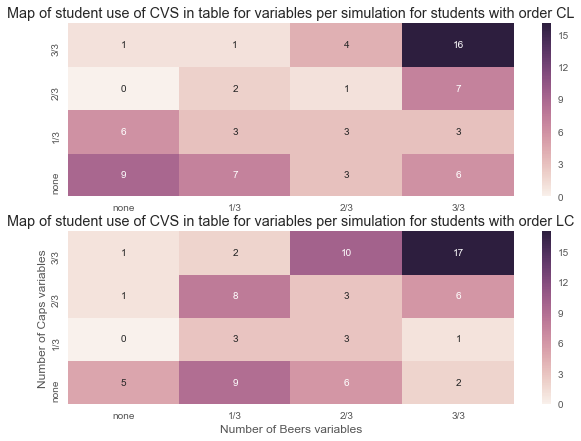

In [11]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)&(table_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order CL')

ax = ax2
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)&(table_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in table for variables per simulation for students with order LC')

When beers sim is second, the heatmap is bottom right triangle heavy, thus students in this condition are more likely to do CVS on more variables in beers. Hypothesis: students tried/practiced CVS in caps and used it more in the beers (second) sim.

When the caps sim is second, different pattern appears. First, there are still students in this condition that are still likely to do CVS in beers but not in caps. However, student who did CVS with 1 or 2 variables in beers are likely to do so with 2 or 3 variable in capacitance (see the cells with 8 adn 10). Students that practiced CVS in beers, were likely to apply it more in caps. More evidence of learning!

## Does order matter in terms of the number of CVS points they have in their table? (More pts = more deliberate, better sampling?)

In [12]:
print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','CL','LC']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='CL')][v].values),1),round(np.mean(table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='LC')][v].values),1)])
## Does order matter in terms of the number of CVS points they plot? (More pts = more deliberate, better sampling?)print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero by activity order.


For all variables except Area there is an increase in sample size when the sim is second. There is a higher increase for beers sim variables.

# Plotting CVS data  - how is it used?

## How many students are plotting CVS data?

In [13]:
print "Percentage of students doing CVS for variable in table and graph."
p = [['',' % in table',' % in graph']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df2[v].values)*100,1),round(np.mean(graph_cvs_df2[v].values)*100,1)])
print tabulate(p)

Percentage of students doing CVS for variable in table and graph.
---------------  ----------  ----------
                 % in table  % in graph
Battery voltage  47.7        22.8
Area             56.4        43.6
Separation       53.0        43.0
Wavelength       59.7        30.9
Width            59.7        44.3
Concentration    65.1        50.3
---------------  ----------  ----------


Again, the quantitative variables are plotted by a similar proportion of students. Battery voltage is rarely used, and Wavelength is used slightly less despite being captured in the table as often as other variables. This is not surprise since plotting this variables involves realized that they have to use trial number to do so.

## Does plotting CVS data change the sample size used?

In [14]:
print "Mean sample size for each variable, excluding sample sizes of zero."
p = [['',' Mean in table','Mean in graph']]
for v in variables:
    p.append([v,round(np.mean(table_cvs_df[table_cvs_df[v]!=0][v].values),1),round(np.mean(table_cvs_df[graph_cvs_df[v]!=0][v].values),1)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero.
---------------  -------------  -------------
                 Mean in table  Mean in graph
Battery voltage  5.9            6.8
Area             6.0            6.7
Separation       5.8            6.4
Wavelength       8.3            10.4
Width            6.8            7.5
Concentration    6.4            6.8
---------------  -------------  -------------


If students plot their CVS-like data, they tend to have a larger sample size, especially for Wavelength. This hints at the fact that students who collect data in a CVS way do so differently depending on their goal: analyze in table or analyze in graph.

## Are student's consistency different in their use of CVS accross sims when plotting CVS data?

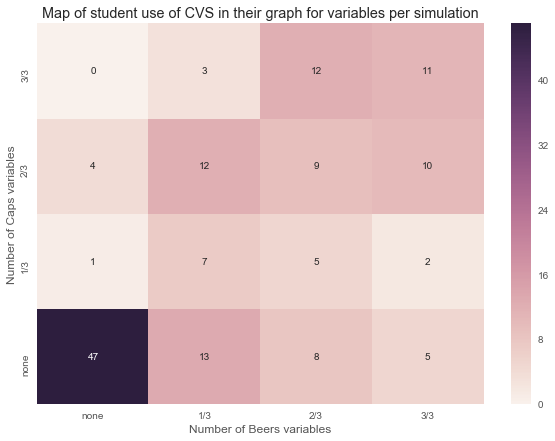

In [15]:
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum beers']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS in their graph for variables per simulation')

The first thing we observe is that almost a third of students don't plot CVS-like data in either sim. The patterns we had when looking at CVS in a table reappear here:
* student who do CVS with 2-3 variables do so consistently accross sims (upper right corner). 
<p> &#9654; CVS proficient students are systematic in their CVS table and graph strategy </p>
* students for don't use CVS in their graph for capacitor might still do so for beers sim.
<p> &#9654; CVS non-proficient students are not systematic in their CVS table and graph strategy </p>

# Activity order and student learning in inquiry - part 2: using graphs.

## Does order matter in their consistency of CVS usage in graphs?

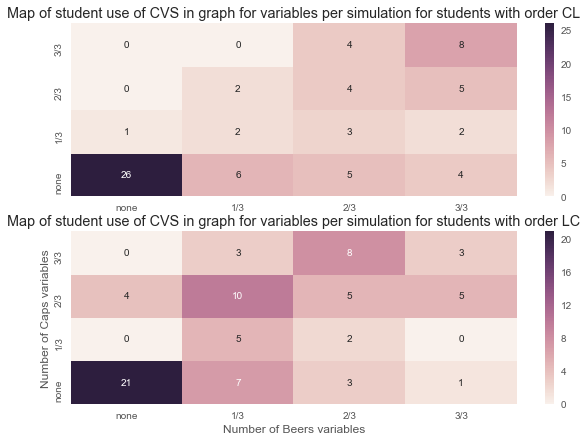

In [16]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum beers']==j)&(graph_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in graph for variables per simulation for students with order CL')

ax = ax2
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(graph_cvs_df2[(graph_cvs_df2['sum caps']==i)&(graph_cvs_df2['sum beers']==j)&(graph_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS in graph for variables per simulation for students with order LC')

Here we see the same patterns as for table.

When beers sim is second, the heatmap is bottom right triangle heavy, thus students in this condition are more likely to do CVS on more variables in beers.

When the caps sim is second, students in this condition that are still likely to do CVS in beers but not in caps and student who did CVS with 1 or 2 variables in beers are likely to do so with 2 or 3 variable in capacitance (see the cells with 8 adn 10).

## Does order matter in terms of the number of CVS points they plot? (More pts = more deliberate, better sampling?)

In [17]:
print "Mean sample size for each variable, excluding sample sizes of zero by activity order."
p = [['','table','','graph','']]
p.append(['','CL','LC','CL','LC'])
for v in variables:
    p.append([v,round(np.mean(table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='CL')][v].values),1),round(np.mean(table_cvs_df[(table_cvs_df[v]!=0)&(table_cvs_df['activity order']=='LC')][v].values),1),round(np.mean(graph_cvs_df[(graph_cvs_df[v]!=0)&(graph_cvs_df['activity order']=='CL')][v].values),1),round(np.mean(graph_cvs_df[(graph_cvs_df[v]!=0)&(graph_cvs_df['activity order']=='LC')][v].values),1)])
print tabulate(p)

Mean sample size for each variable, excluding sample sizes of zero by activity order.
---------------  -----  ---  -----  ----
                 table       graph
                 CL     LC   CL     LC
Battery voltage  5.8    6.1  5.9    6.7
Area             6.2    6.0  6.6    6.2
Separation       5.6    6.0  5.8    5.8
Wavelength       8.8    7.8  9.5    10.0
Width            7.7    6.0  7.5    6.6
Concentration    6.7    6.1  6.9    6.1
---------------  -----  ---  -----  ----


Increase in sample size with second sim variables is still present for quantitative beers sim variables, but that's it... Not sure what to make of this nor if it matter, nor if it's significant.